In [65]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of Webtris failed: Traceback (most recent call last):
  File "/Users/markd/projects/he/he/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/markd/projects/he/he/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/markd/projects/he/Webtris/__init__.py", line 12, in <module>
    class MIDAS:


In [66]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from shapely.geometry import Point
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import os
import re
import time

from Webtris import MIDAS
from Webtris.utils import plot_report, show_sites

sns.set_style("whitegrid")
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# MIDAS sites (Motorway Incident Detection and Automatic Signalling)

In [74]:
midas = MIDAS(version=1.0)

### MIDAS sites locations

In [135]:
midas_sites = midas.sites()

In [173]:
len(midas_sites["link"].unique())

2794

In [100]:
midas_sites.groupby(["link"]).size().sort_values(ascending=False).head(30)

link
102004801    42
102004601    41
200047941    31
108018902    29
123008901    29
110005202    28
200113967    28
102005102    27
103048301    27
123001701    27
199056602    27
102004302    27
103049201    26
112006401    25
200117997    25
123016901    25
199086201    24
199065401    24
199131801    23
123002502    23
199056101    23
102003201    23
199131301    22
109003001    21
125007101    21
107033101    21
112006601    20
112007301    20
199055701    20
109001401    20
dtype: int64

In [136]:
sites_199055701 = ",".join(midas_sites[midas_sites["link"] == "199055701"].Id.values)

In [137]:
df_199055701 = midas.daily_report(
    start="31-10-2016", end="04-11-2016", sites=sites_199055701
)

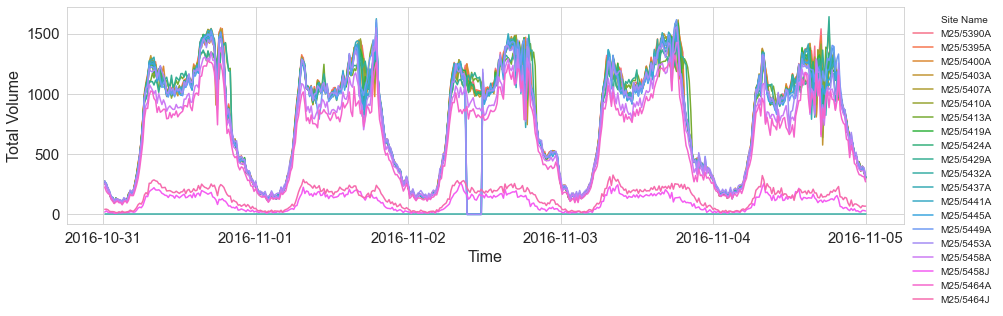

In [115]:
plot_report(df_199055701)

> MIDAS Sites within the same link, drastically different volumes

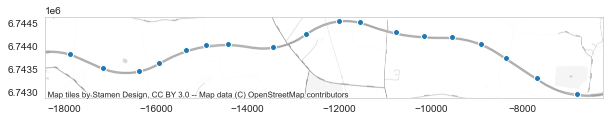

In [117]:
show_sites(
    midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].unique())],
    backend="geopandas",
)

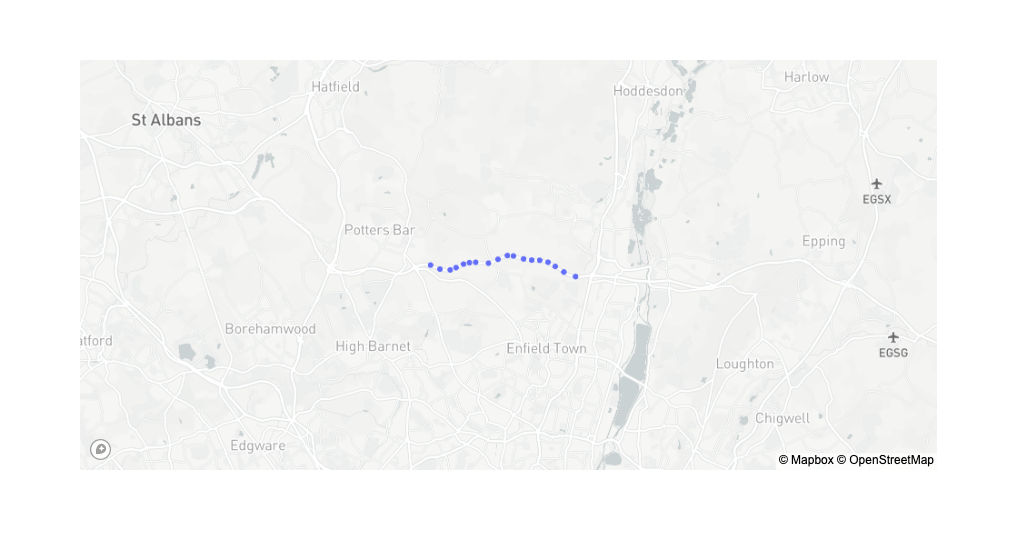

In [170]:
show_sites(
    midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].values)],
    backend="mapbox",
)

### Random sites example

In [109]:
df = midas.daily_report(start="01-11-2016", end="05-11-2016", sites="1,2,3,5,6")

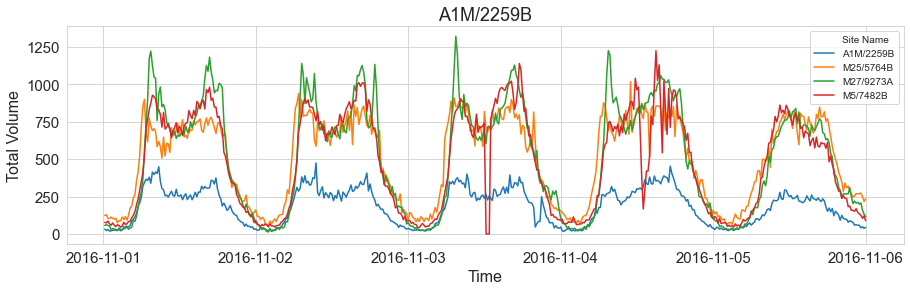

In [110]:
plot_report(df)

# Network models

In [125]:
hapms_file = "hapms/network20200302.shp"

In [126]:
hapms = gpd.read_file(hapms_file)

In [130]:
hapms.crs = "epsg:27700"

In [165]:
midas_buff = midas_sites[
    midas_sites["Description"].isin(df_199055701["Site Name"].unique())
].copy()
midas_buff["geometry"] = midas_buff["geometry"].buffer(5)
sites_hapms_join = gpd.sjoin(midas_buff, hapms, how="left", op="intersects")

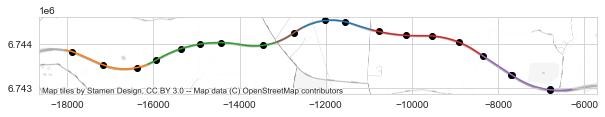

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
i = -1
for sect in sites_hapms_join["sect_label"].unique():
    i = i + 1
    hapms[hapms["sect_label"].isin([sect])].to_crs("epsg:3857").plot(
        ax=ax, color=sns.color_palette()[i]
    )
midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].unique())].to_crs(
    "epsg:3857"
).plot(ax=ax, color="k")
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

> multiple HAPMS sections in a single SRN link. \
This required a buffering of 5 meters ot match line segments with points
as the points are not exactly located to the road resolution

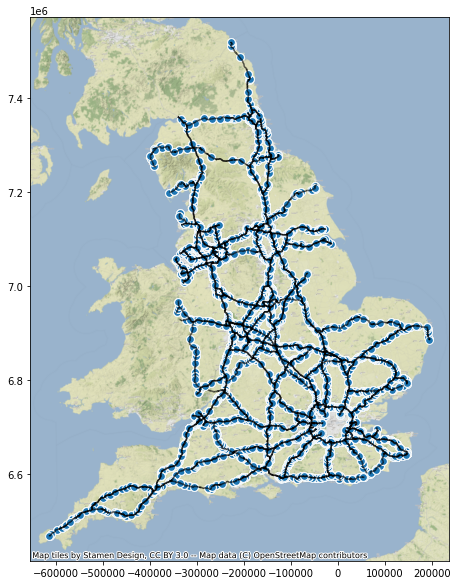

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sites_clean.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", alpha=1, markersize=60)
hapms_gdf.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

In [196]:
sites_clean_buff = sites_clean.copy()
sites_clean_buff["geometry"] = sites_clean_buff["geometry"].buffer(10)
sites_hapms_join = gpd.sjoin(sites_clean_buff, hapms_gdf, how="left", op="intersects")

In [197]:
midas_hapms = pd.merge(
    sites_clean, sites_hapms_join[["Id", "sect_label"]], on="Id", how="left"
)

In [202]:
sites_hapms_join[["sect_label", "location"]]

,sect_label,location
1,0500A1M/298,None
2,1800M5/201,M5 Northbound. From Centre of Junction 7 Round...
2,1800M5/207,M5 Junction 7 Northbound Entry Slip.
3,1700M3/969,From start spur to J14 Chilworth MP 116.8 + 63...
4,1500M25/175,End of HRA over A127 to end of NB slip on fro...
...,...,...
17842,4600M5/16,M5 Southbound. From start of Oldbury viaduct t...
17843,0600M62/180,EB 34/0 (end of access) - 35/39
17844,4200M60/933,ACW link from M62 (starts at split to M60 CW -...
17845,0600M62/122,EB 28/5+50 - 29/4+90 (c/l M6)


In [200]:
midas_hapms[midas_hapms["sect_label"].isna()]

,Id,Name,Description,Longitude,Latitude,Status,link,direction,geometry,sect_label
8,14,MIDAS site at A2/8392M priority 1 on link 2000...,A2/8392M,0.381381,51.408466,Active,200045660,Westbound,POINT (565720.027 170406.050),NaN
150,170,MIDAS site at A2/8369J priority 1 on link 2000...,A2/8369J,0.353038,51.417959,Active,200045742,Eastbound,POINT (563715.080 171398.004),NaN
202,230,MIDAS site at M1/2463B priority 1 on link 1080...,M1/2463B,-0.418584,51.829537,Active,108022201,Southbound,POINT (509073.643 215728.883),NaN
223,259,MIDAS site at A2/8378L priority 1 on link 2000...,A2/8378L,0.363333,51.414002,Active,200045674,Westbound,POINT (564445.066 170981.016),NaN
240,275,MIDAS site at M1/2389A priority 1 on link 2000...,M1/2389A,-0.416364,51.763758,Active,200047643,Northbound,POINT (509385.563 208416.785),NaN
...,...,...,...,...,...,...,...,...,...,...
11728,17880,MIDAS site at A1/2046A priority 1 on link 1240...,A1/2046A,-0.252142,52.351802,Active,124000101,Northbound,POINT (519144.330 274074.679),NaN
11733,17885,MIDAS site at A1/2018B priority 1 on link 2001...,A1/2018B,-0.247101,52.327036,Active,200128513,Southbound,POINT (519554.362 271328.598),NaN
11749,17899,MIDAS site at A1/2018A priority 1 on link 2001...,A1/2018A,-0.247404,52.327176,Active,200128516,Northbound,POINT (519533.361 271343.598),NaN
11750,17900,MIDAS site at A1/2021M priority 0 on link 1990...,A1/2021M,-0.247304,52.329692,Active,199033702,Southbound,POINT (519533.358 271623.604),NaN


In [210]:
fig, ax = plt.subplots(figsize=(20, 20))
sites_clean.loc[[10784]].to_crs("epsg:3857").plot(ax=ax)
midas_hapms.to_crs("epsg:3857").plot(ax=ax)
ctx.add_basemap(ax, zoom=10)

In [348]:
midas_hapms["geometry"] = midas_hapms["geometry"].buffer(100)

In [396]:
len(midas_hapms[~midas_hapms["sect_label"].isna()]) / len(midas_hapms)

0.24825513765025203

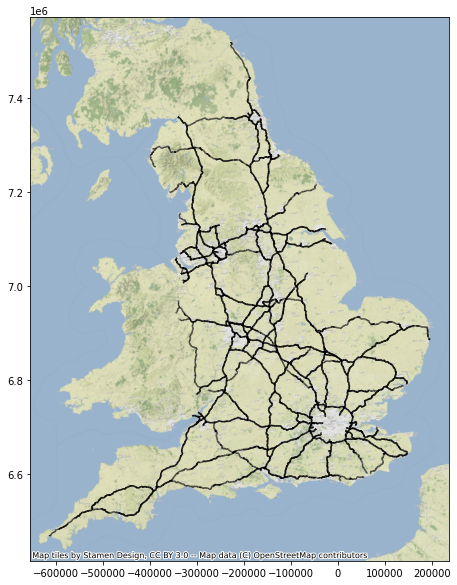

In [351]:
fig, ax = plt.subplots(figsize=(10, 10))
midas_hapms.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", color="blue", alpha=1)
hapms_gdf.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

# HATRIS

In [13]:
df_hatris = pd.read_csv("/Users/markd/projects/he/hatris.csv")


def start_pipe(df):
    return df.copy()


def clean(df):
    df.dropna(subset=["StartX"], inplace=True)
    return df


def create_geom(df):
    df["geometry"] = df.apply(
        lambda x: LineString([(x["StartX"], x["StartY"]), (x["EndX"], x["EndY"])]),
        axis=1,
    )

    return df


def convert_to_gdf(df):
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = "epsg:27700"
    return gdf

In [331]:
hatris_links = (
    df_hatris.pipe(start_pipe).pipe(clean).pipe(create_geom).pipe(convert_to_gdf)
)

(7400000.0, 7600000.0)

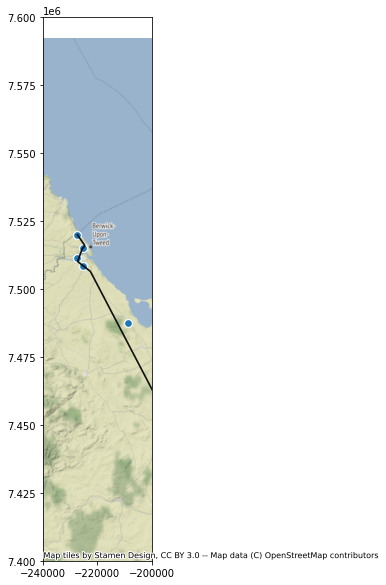

In [407]:
fig, ax = plt.subplots(figsize=(10, 10))
sites_clean.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", alpha=1, markersize=60)
hatris_links.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)
ax.set_xlim([-240000, -200000])
ax.set_ylim([7.4e6, 7.6e6])

In [403]:
sites_clean_buff = sites_clean.copy()
sites_clean_buff["geometry"] = sites_clean_buff["geometry"].buffer(100)
midas_hatris = gpd.sjoin(sites_clean_buff, hatris_links, how="left", op="intersects")

In [404]:
midas_hatris["geometry"] = midas_hatris["geometry"].buffer(5000)

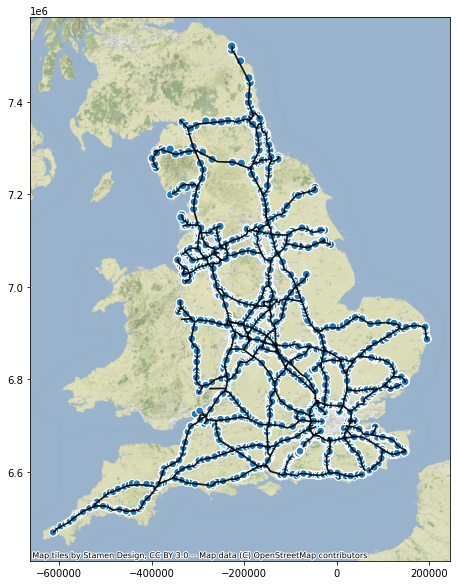

In [405]:
fig, ax = plt.subplots(figsize=(10, 10))
midas_hatris.to_crs("epsg:3857").plot(ax=ax, edgecolor="w")
hatris_links.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

In [402]:
print(len(midas_hatris))
print(len(midas_hatris[~midas_hatris["LinkRef"].isna()]))

12825
5882


# NTIS

## Selenium

In [ ]:
chromedriver = "/Users/markd/projects/he/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [188]:
p = re.compile("[a-zA-Z]\d+")

In [240]:
re.match(p, "A5183")

<re.Match object; span=(0, 5), match='A5183'>

In [227]:
df_links = pd.DataFrame()

In [231]:
roads = []

""


In [245]:
def get_href():
    # go to website click on link
    driver = webdriver.Chrome(chromedriver)
    url = "http://tris.highwaysengland.co.uk/detail/journeytimedata"
    driver.get(url)
    elems = driver.find_elements_by_xpath("//a[@href]")
    return elems, driver


def process(elems, driver, df_links):
    for elem in elems:
        if re.match(p, elem.text) and elem.text not in roads:
            print(elem.text)
            driver.find_element_by_link_text(elem.text).click()
            time.sleep(7)
            driver.find_element_by_xpath('//button[text()=" 2020"]').click()
            html_doc = driver.page_source

            soup = BeautifulSoup(html_doc, "html.parser")

            try:
                links_first_month_2020 = (
                    soup.find_all("button", text=" 2020")[0]
                    .next_element.next_element.next_element.find_all("table")[0]
                    .find_all("a", target="_blank")
                )
                for a in links_first_month_2020[:1]:
                    u = "http://tris.highwaysengland.co.uk" + a["href"]
                    df = pd.read_csv(
                        u, compression="zip", header=0, sep=",", quotechar='"'
                    )
                    df = df.drop_duplicates(subset=[" NTIS Link Number"], keep="first")
                    df_links = pd.concat([df_links, df])

            except:
                pass

            roads.append(elem.text)
            return True, df_links
    return False, df_links


while True:
    elems, driver = get_href()
    bl, df_links = process(elems, driver, df_links)
    if not bl:
        break

M606
M61
M62
M621
M65
M66
M67
M69
M6-TOLL
M74


In [247]:
df_links.to_csv("df_links.csv", index=False)

In [251]:
df_links = df_links[
    [
        " NTIS Link Number",
        " Road",
        " Carriageway",
        " NTIS Link Description",
        " NTIS Model Version",
        " Start Node Coordinates",
        " End Node Coordinates",
    ]
].copy()

In [252]:
df_links.head()

,NTIS Link Number,Road,Carriageway,NTIS Link Description,NTIS Model Version,Start Node Coordinates,End Node Coordinates
0,120014302,A1,entrySlipRoad,A1 northbound access at a minor junction betwe...,1.0,54.920707478275297 ; -1.612915462735710,54.921472708741298 ; -1.619039785342490
0,200049762,A10,roundabout,roundabout at M25 J25/A10,1.0,51.682682181170698 ; -0.050911278604530,51.683488056159597 ; -0.050703064845945
0,200075666,A1001,roundabout,A1001 northbound between A1(M) J2 and A1(M) J3,1.0,51.740848259774900 ; -0.238418793719917,51.750885318343400 ; -0.243939235693910
0,200052199,A1023,roundabout,A1023 northbound between M25 and B186,1.0,51.608514667537101 ; 0.264002470421456,51.608818686159502 ; 0.265490831462923
0,200005499,A1033,roundabout,A1033 eastbound at a minor junction between A6...,1.0,53.748488436610899 ; -0.284617107235886,53.748375852469799 ; -0.284288037251645


In [254]:
df_links.columns = [col.strip() for col in df_links.columns]

In [256]:
from shapely.geometry import LineString

In [262]:
df_links.columns

Index(['NTIS Link Number', 'Road', 'Carriageway', 'NTIS Link Description',
       'NTIS Model Version', 'Start Node Coordinates', 'End Node Coordinates'],
      dtype='object')

In [272]:
df_links.head(1)

,NTIS Link Number,Road,Carriageway,NTIS Link Description,NTIS Model Version,Start Node Coordinates,End Node Coordinates,geometry
0,120014302,A1,entrySlipRoad,A1 northbound access at a minor junction betwe...,1.0,54.920707478275297 ; -1.612915462735710,54.921472708741298 ; -1.619039785342490,"LINESTRING (-1.61292 54.92071, -1.61904 54.92147)"


In [264]:
def create_link(x):
    lat1 = float(x["Start Node Coordinates"].split(";")[0].strip())
    lon1 = float(x["Start Node Coordinates"].split(";")[1].strip())

    lat2 = float(x["End Node Coordinates"].split(";")[0].strip())
    lon2 = float(x["End Node Coordinates"].split(";")[1].strip())

    return LineString([(lon1, lat1), (lon2, lat2)])


df_links["geometry"] = df_links.apply(create_link, axis=1)

In [269]:
gdf_links = gpd.GeoDataFrame(df_links)
gdf_links.crs = "epsg:4326"
gdf_links = gdf_links.to_crs("epsg:27700")

In [20]:
gdf_links.plot(linewidth=7, figsize=(10, 10))

NameError: name 'gdf_links' is not defined